## Importing Libraries

In [1]:
import numpy as np
import os
import tensorflow.keras.applications.mobilenet
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Activation, Dropout, Convolution2D, GlobalAveragePooling2D

# Loading Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
#The 9 different classes in the dataset (0-8)
classes = {'Actinic keratosis':0,
           'Atopic Dermatitis':1,
           'Benign keratosis':2,
           'Dermatofibroma':3,
           'Melanocytic nevus':4,
           'Melanoma':5,
           'Squamous cell carcinoma':6,
           'Tinea Ringworm Candidiasis':7,
           'Vascular lesion':8 }

num_of_class = 9  #Total classes
def class_map(val): return classes[val]

# Loading Training Data

In [10]:
Train_data_path = r'/content/drive/MyDrive/Split_smol/train'

# Data Preprocessing

In [11]:
import PIL
import cv2
dataset = []

for dir in os.listdir(Train_data_path):
    path = os.path.join(Train_data_path, dir)
    for img in os.listdir(path):
        newPath = os.path.join(path, img)
        try:
            imgPath=PIL.Image.open(newPath)
            img_path=imgPath.convert('RGB')
            image = np.asarray(img_path)
            image = cv2.resize(image, (240,240))
            image=image/255.
            dataset.append([image, dir])
        except FileNotFoundError:
            print('Image file not found.')

In [12]:
data, labels = zip(*dataset)
temp = list(map(class_map, labels))

In [13]:
import keras
labels = keras.utils.to_categorical(temp)

In [14]:
cnt=0
for i in data:
    if i.shape!=(240, 240, 3):
        cnt=cnt+1
print(cnt)

0


# MobileNet Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Convolution2D, Activation, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def mobilenet():
    # Load MobileNet pre-trained weights
    base_model = MobileNet(input_shape=(240, 240, 3), include_top=False, weights='imagenet')
    # Freeze MobileNet layers
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        Dropout(0.3),
        Convolution2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
        GlobalAveragePooling2D(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(9, activation='softmax')
    ])

    # Define optimizer
    optimizer = Adam(lr=0.00001)
    # Compile model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [16]:
# define the model
model_mobile = mobilenet()
model_mobile.summary()

17225924/17225924 [==============================] - 0s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 7, 7, 1024)        0         
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          294944    
                                                                 
 global_average_pooling2d (  (None, 32)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dense_1 (Dense)             (None, 9)                 1

In [20]:
history_mobile=model_mobile.fit(np.array(data), np.array(labels), epochs = 5 , shuffle = True)

Epoch 1/5
22/22 [==============================] - 45s 2s/step - loss: 0.3059 - accuracy: 0.9455
Epoch 2/5
22/22 [==============================] - 38s 2s/step - loss: 0.2540 - accuracy: 0.9713
Epoch 3/5
22/22 [==============================] - 36s 2s/step - loss: 0.2242 - accuracy: 0.9842
Epoch 4/5
22/22 [==============================] - 37s 2s/step - loss: 0.2033 - accuracy: 0.9885
Epoch 5/5
22/22 [==============================] - 38s 2s/step - loss: 0.1858 - accuracy: 0.9928


# Saving the Model

In [18]:
# save the model for later use
model_mobile.save("skin_disease_model_ISIC_mobilenet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Loading Test Data

In [22]:
Test_data_path = r'/content/drive/MyDrive/Split_smol/val'

In [24]:
import PIL
import cv2

dataset_testing=[]#Creating a list for test data

for dir in os.listdir(Test_data_path):
    path = os.path.join(Test_data_path, dir)
    for images in os.listdir(path):
        new_path = os.path.join(path, images)
        img_path=PIL.Image.open(new_path)
        img_path=img_path.convert('RGB')
        image = np.asarray(img_path)
        image = cv2.resize(image, (240, 240))
        img = image/255.
        dataset_testing.append([img, dir])

        from PIL import Image

In [25]:
test_data, test_label = zip(*dataset_testing)
test_temp = list(map(class_map, test_label))

In [26]:
import keras
test_label = keras.utils.to_categorical(test_temp)

In [27]:
model_mobile.evaluate(np.array(test_data), np.array(test_label))

6/6 [==============================] - 12s 2s/step - loss: 0.6720 - accuracy: 0.8232


[0.6719552278518677, 0.8232043981552124]

# Evaluation

In [28]:
# Create a confusion matrix and the classification report
!pip install scikit-plot
!pip install scikit-learn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import scikitplot
import matplotlib.pyplot as plt

# Make predictions
def make_preds(model):
    label_preds = model.predict(np.array(test_data))

    def one_hot_highest(arr):
        for row in arr:
            max_val = max(row)
            for i in range(len(row)):
                if row[i] == max_val:
                    row[i] = 1
                else:
                    row[i] = 0
        return arr

    arr=one_hot_highest(label_preds) #one hot
    arr2= one_hot_highest(test_label)

    labelenc=[]
    for i in range (0, len(arr)):
        flag=0
        for j in range (0,9):
            if arr[i][j]==1:
                labelenc.append(j)
                flag=1
    labelenctest=[]
    for i in range (0, len(arr2)):
        for j in range (0,9):
            if arr2[i][j]==1:
                labelenctest.append(j)

    print("Predicted Labels:", labelenc)
    print("True Labels:", labelenctest)


    scikitplot.metrics.plot_confusion_matrix(labelenctest,labelenc)
    # Save confusion matrix to PNG
    plt.savefig("confusion_matrix.png")

    report = classification_report(labelenctest,labelenc, digits=4)
    print(report)


6/6 [==============================] - 16s 3s/step
Predicted Labels: [0, 0, 0, 3, 0, 6, 0, 3, 0, 0, 0, 0, 0, 6, 6, 6, 0, 0, 0, 3, 7, 7, 7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 3, 3, 3, 6, 3, 3, 3, 6, 3, 6, 3, 3, 3, 3, 0, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 5, 2, 5, 6, 6, 0, 6, 6, 6, 6, 6, 3, 5, 6, 0, 0, 6, 6, 6, 6, 6, 6, 0, 5, 5, 5, 6, 3, 6, 3, 5, 6, 4, 5, 6, 5, 0, 4, 5, 5, 2, 6, 5]
True Labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2

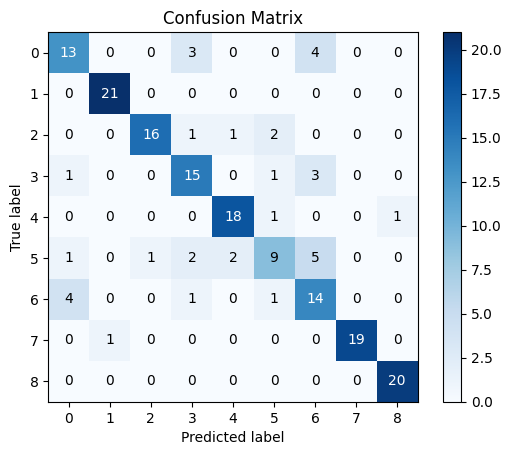

In [ ]:
make_preds(model_mobile)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Separate images and labels
X_test = np.array([data[0] for data in dataset_testing])
y_test = np.array([data[1] for data in dataset_testing])

# Make predictions
y_pred_prob = model_mobile.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
label_to_index = {class_name: index for index, class_name in enumerate(set(y_test))}
y_test_numeric = np.array([label_to_index[label] for label in y_test])
y_pred_numeric = np.argmax(y_pred_prob, axis=1)


6/6 [==============================] - 20s 3s/step


6/6 [==============================] - 18s 3s/step


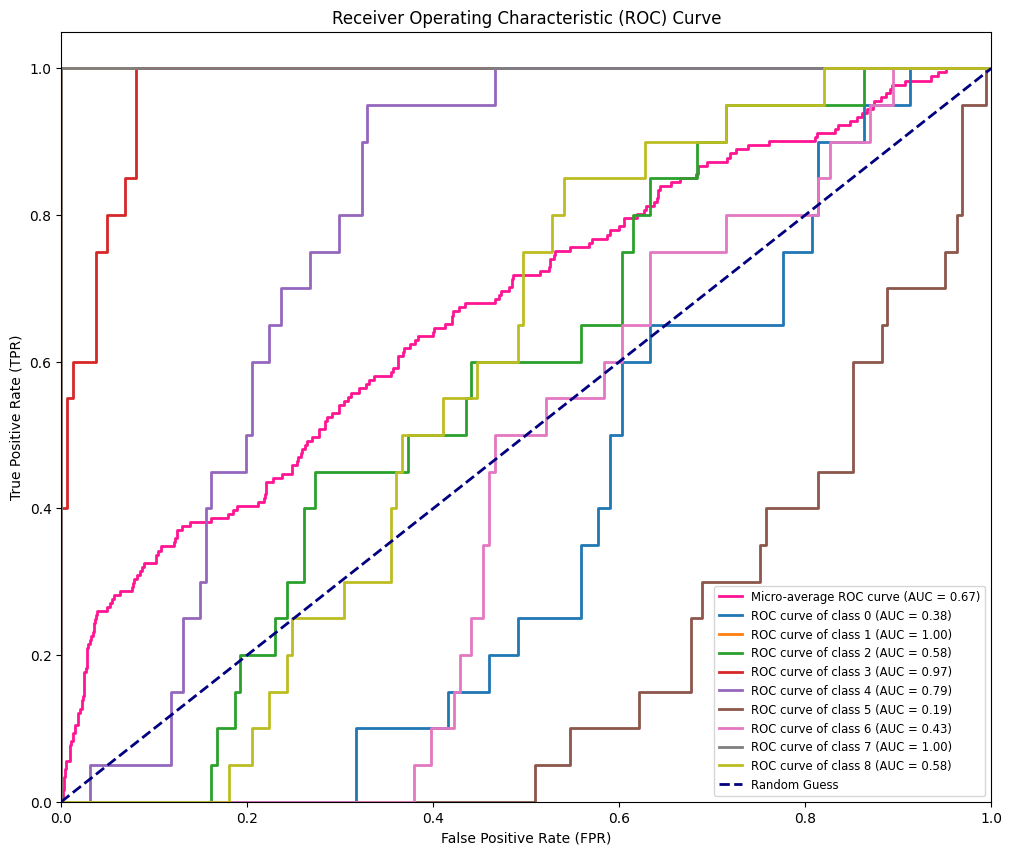

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Binarize the labels for multiclass classification
y_test_binarized = label_binarize(y_test_numeric, classes=np.unique(y_test_numeric))

# Compute predicted probabilities for each class
y_score = model_mobile.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_of_class):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot the ROC curve for each class
plt.figure(figsize=(12,10))
plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=2, label='Micro-average ROC curve (AUC = %0.2f)' % roc_auc_micro)
for i in range(num_of_class):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class %d (AUC = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right', fontsize='small')
plt.savefig("ROC_CURVE_mobile.png")
plt.show()